In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import CategoricalNB, ComplementNB, BernoulliNB
from sklearn.metrics import plot_roc_curve, roc_auc_score, plot_confusion_matrix, roc_curve, confusion_matrix, auc, accuracy_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold

from pipelines import nested_cross_validate_score, pipeline_Donker, pipeline_Richard
from transform import combine_tsv_files
from utils import double_cross_validate, get_sub_pipeline
from views import plot_roc_curve

In [2]:
# Difference genomic variable.
X, y = combine_tsv_files(
    "output/all__gene__up_or_down__No. Mutant Molecules per mL.tsv",
    "output/all__gene__up_or_down__CNV Score.tsv",
)

y_resp = y['response_grouped'].map({
    'non responder (sd+pd)': 'non responder (sd+pd+ne)', 
    'non evaluable (ne)': 'non responder (sd+pd+ne)',
    'responder (pr+cr)': 'responder (pr+cr)',
})

In [3]:
y_OS = y['OS_months'].apply(lambda x: '<1yr' if x < 12.0 else r'>=1yr')
# Verify that none of <1yr group is censored.
assert np.all(y[y['OS_months'] < 12.0]['Censor_OS'] == 1.0)

y_PFS = y['PFS_months'].apply(lambda x: '<1yr' if x < 12.0 else r'>=1yr')
# Verify that none of <1yr group is censored.
assert np.all(y[y['PFS_months'] < 12.0]['Censor_progression'] == 'progression of disease')

In [4]:
@double_cross_validate(5, 5)
def metrics_binary_class(clf, X, y, positive_class):
    mean_fpr = np.linspace(0, 1, 100)
    metrics = {}
    class_index = list(clf.classes_).index(positive_class)
    y_prob = clf.predict_proba(X)[:, class_index]
    y_pred = clf.predict(X)
    fpr, tpr, _ = roc_curve(y, y_prob, pos_label=positive_class)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    metrics.update(
        {
            f"{positive_class}__tprs": interp_tpr,
            f"{positive_class}__fprs": mean_fpr,
            f"{positive_class}__roc_auc": roc_auc_score(y, y_prob),
            f"{positive_class}__accuracy": accuracy_score(y, y_pred),
            f"{positive_class}__confusion_matrix": confusion_matrix(
                y, y_pred, normalize="true"
            ),
        }
    )
    print(positive_class, roc_auc_score(y, y_prob))
    return metrics

In [5]:
@double_cross_validate(5, 5)
def multi_class_metrics(clf, X, y):
    mean_fpr = np.linspace(0, 1, 100)
    metrics = {}
    # Make one v.s. rest classification.
    for class_name in ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']:
        ybin_true = y == class_name
        class_index = list(clf.classes_).index(class_name)
        y_prob = clf.predict_proba(X)[:, class_index]
        ybin_pred = clf.predict(X) == class_name
        fpr, tpr, _ = roc_curve(ybin_true, y_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        metrics.update({
            f'{class_name}__tprs': interp_tpr,
            f'{class_name}__fprs': mean_fpr,
            f'{class_name}__roc_auc': roc_auc_score(ybin_true, y_prob),
            f'{class_name}__accuracy': accuracy_score(ybin_true, ybin_pred),
            f'{class_name}__confusion_matrix': confusion_matrix(ybin_true, ybin_pred, normalize='true'),
        })
        print(class_name, roc_auc_score(ybin_true, y_prob))
    return metrics

# Clinical baseline model

In [6]:
pr = pipeline_Richard(ComplementNB())

In [7]:
resp_mean, resp_std = metrics_binary_class(pr, X, y_resp, positive_class="responder (pr+cr)")

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


responder (pr+cr) 0.5705128205128205
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


responder (pr+cr) 0.576923076923077
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


responder (pr+cr) 0.7072649572649572
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


responder (pr+cr) 0.25854700854700857
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.9s finished


responder (pr+cr) 0.5266666666666666


In [8]:
PFS_mean, PFS_std = metrics_binary_class(pr, X, y_PFS, positive_class='>=1yr')

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>=1yr 0.6736111111111112
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.7s finished


>=1yr 0.6388888888888888
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>=1yr 0.7307692307692307
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>=1yr 0.5876068376068376
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.0s finished


>=1yr 0.5552884615384616


In [9]:
OS_mean, OS_std = metrics_binary_class(pr, X, y_OS, positive_class='>=1yr')

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.7s finished


>=1yr 0.6598639455782314
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>=1yr 0.7925170068027212
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.7s finished


>=1yr 0.7704081632653061
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>=1yr 0.6241496598639455
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.4s finished


>=1yr 0.6589285714285714


Accuracy: 0.5405042016806723


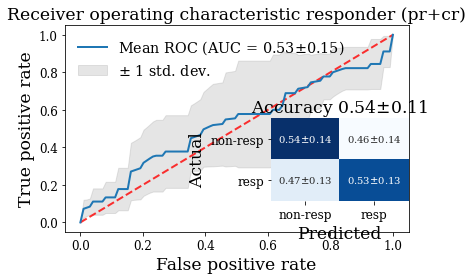

In [10]:
plt.rc("font", family="serif")
# plt.figure(figsize=(4, 3))
plot_roc_curve(resp_mean, resp_std, class_name='responder (pr+cr)', labels=['non-resp', 'resp'])
plt.savefig('response_prediction_clinical.png')

Accuracy: 0.6146218487394958


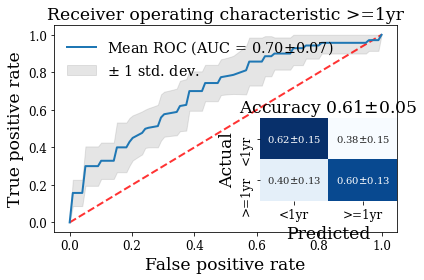

In [11]:
plot_roc_curve(OS_mean, OS_std, class_name='>=1yr', labels=['<1yr', '>=1yr'])
plt.savefig('os_prediction_clinical.png')

Accuracy: 0.5801680672268906


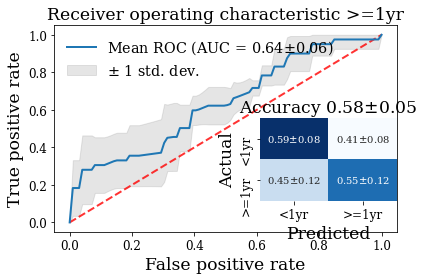

In [12]:
plot_roc_curve(PFS_mean, PFS_std, class_name='>=1yr', labels=['<1yr', '>=1yr'])
plt.savefig('pfs_prediction_clinical.png')

# Clinical + genomic omdel

In [13]:
# p = pipeline_Donker(CategoricalNB())
p = pipeline_Donker(ComplementNB())

In [14]:
resp_mean, resp_std = metrics_binary_class(p, X, y_resp, positive_class="responder (pr+cr)")

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.0s finished


responder (pr+cr) 0.735042735042735
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished


responder (pr+cr) 0.658119658119658
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished


responder (pr+cr) 0.670940170940171
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished


responder (pr+cr) 0.6495726495726495
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished


responder (pr+cr) 0.6533333333333333


In [15]:
OS_mean, OS_std = metrics_binary_class(p, X, y_OS, positive_class='>=1yr')

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished


>=1yr 0.6734693877551021
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished


>=1yr 0.7482993197278912
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished


>=1yr 0.6632653061224489
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.4s finished


>=1yr 0.7006802721088435
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished


>=1yr 0.807142857142857


In [16]:
PFS_mean, PFS_std = metrics_binary_class(p, X, y_PFS, positive_class='>=1yr')

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.5s finished


>=1yr 0.7314814814814815
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.5s finished


>=1yr 0.8101851851851852
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.2s finished


>=1yr 0.6367521367521367
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.8s finished


>=1yr 0.7564102564102564
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.5s finished


>=1yr 0.5817307692307692


# Predicting responder vs non-evaluable and non-responders

Accuracy: 0.7068907563025212


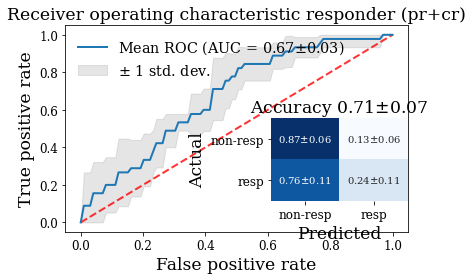

In [17]:
from views import plot_roc_curve
plt.rc("font", family="serif")
# plt.figure(figsize=(4, 3))
plot_roc_curve(resp_mean, resp_std, class_name='responder (pr+cr)', labels=['non-resp', 'resp'])
plt.savefig('response_prediction.png')

## Predicting overall survival

Accuracy: 0.6786554621848738


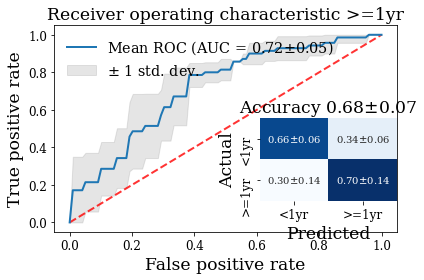

In [18]:
plot_roc_curve(OS_mean, OS_std, class_name='>=1yr', labels=['<1yr', '>=1yr'])
plt.savefig('os_prediction.png')

## Predicting progression free survival

Accuracy: 0.7119327731092437


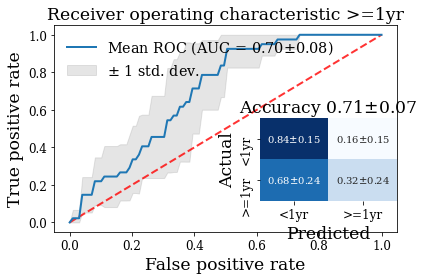

In [19]:
plot_roc_curve(PFS_mean, PFS_std, class_name='>=1yr', labels=['<1yr', '>=1yr'])
plt.savefig('pfs_prediction.png')

# Predicting responders, non-responders _and_ non-evaluable.

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.5s finished


non responder (sd+pd) 0.677536231884058
responder (pr+cr) 0.6367521367521367
non evaluable (ne) 0.9166666666666666
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.9s finished


non responder (sd+pd) 0.7282608695652173
responder (pr+cr) 0.7606837606837606
non evaluable (ne) 0.8125
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.6s finished


non responder (sd+pd) 0.6195652173913044
responder (pr+cr) 0.6965811965811965
non evaluable (ne) 0.6666666666666666
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.8s finished


non responder (sd+pd) 0.6123188405797102
responder (pr+cr) 0.641025641025641
non evaluable (ne) 0.5416666666666666
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.0s finished


non responder (sd+pd) 0.6287878787878788
responder (pr+cr) 0.7288888888888889
non evaluable (ne) 0.07526881720430108
Accuracy: 0.6717647058823528
Accuracy: 0.7352941176470589
Accuracy: 0.8672268907563027


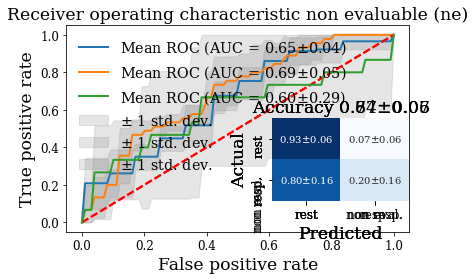

In [20]:
p.fit(X, y['response_grouped'])
m_mean, m_std = multi_class_metrics(p, X, y['response_grouped'])
for class_name in ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']:
    plot_roc_curve(m_mean, m_std, class_name)